# PSP analysis 

In this note, we analyze a dataset for Progressive Supranuclear Palsy (PSP), which includes RNA-Seq data from 25 PSP patients and 16 controls with total of 104 transcriptom.

- Our analysis begins with a 3-fold cross-validation using XGBoost, where we compute and plot the average AUC, specificity, sensitivity, and accuracy scores with standard deviation error bars.

- We then compare XGBoost with other models such as Random Forest, CatBoost, and SVM. Our comparison reveals clear overfitting issues in Random Forest, CatBoost, and SVM.

- To address this, we perform a 5-fold cross-validation and explore hyperparameters for these models, but the overfitting issue persists.

- To mitigate this, we conduct feature importance selection to identify the top 30 genes based on the models previously mentioned, and focus on the common genes among these top selections, which total 5 genes.

- We then apply Logistic Regression and

- CatBoost based on these common genes, observing that while these models show high sensitivity, they exhibit lower specificity.

- Finally, we investigate Lasso Regression and Ridge Regression as additional methods. We find that Lasso Regression effectively mitigates overfitting, whereas Ridge Regression continues to suffer from overfitting issues.

In [7]:
import shap
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold


In [2]:
path1=Path("/Users/zainabnazari/Desktop/psp")

In [12]:
psp_data=pd.read_csv(path1/"DEGs_102_intesect_edgeR_vs_Limma_vs_DESeq2_Pval_5pc_2fc_with_IDs.txt",delimiter='\t')
print(psp_data.shape)
print(psp_data['Class'].value_counts())
psp_data.head(10)

(41, 104)
PSP    25
CTR    16
Name: Class, dtype: int64


,ENST00000373606,ENST00000395496,ENST00000380265,ENST00000636319,ENST00000374176,ENST00000514815,ENST00000490311,ENST00000484279,ENST00000472481,ENST00000294256,...,ENST00000356891,ENST00000377685,ENST00000429892,ENST00000511980,ENST00000362698,ENST00000391141,ENST00000481445,ENST00000293842,Class,ID
0,1.288816,-1.882510,1.621093,2.572735,1.808860,-1.234000,1.423694,0.256728,1.691537,1.376957,...,1.547033,3.157894,-4.354783,1.184119,0.520252,0.467694,-1.419551,0.570963,CTR,CTR001
1,1.506875,-1.785866,-4.354783,1.715456,2.659513,-0.912864,-1.086667,2.514848,0.762630,-3.489044,...,-3.857925,-2.561170,-2.254110,2.173043,0.939312,0.745441,2.179457,1.162930,CTR,CTR002
2,1.556950,-2.687329,1.657670,0.754520,2.359989,1.269290,-1.361125,1.724210,2.496787,-1.934417,...,-4.354783,1.482014,1.004465,1.064401,0.876564,0.539077,-3.149440,0.153984,CTR,CTR003
3,0.165244,-2.114075,-2.945458,-1.206400,1.946038,1.343601,-1.275391,1.366427,3.191344,2.062438,...,0.028821,0.289874,-0.153984,4.118564,0.359791,0.426475,-2.114075,0.720260,CTR,CTR004
4,0.890442,-1.664276,0.183833,0.968123,4.112507,-1.977253,-1.407240,-1.664276,2.259018,-0.590374,...,1.027390,2.465978,-2.098733,-1.123208,0.018404,0.103489,-0.635628,0.825138,CTR,CTR005
5,0.553468,-1.809297,-2.890486,-2.044907,2.054712,1.539948,1.622840,2.039705,2.216925,-3.828892,...,0.750666,-0.668259,1.440621,1.632875,0.466366,1.452001,1.888769,1.701228,CTR,CTR006
6,0.372680,2.272936,0.153191,-0.556137,1.196267,1.530812,0.882012,2.839698,2.222477,-0.389906,...,-0.269466,-0.080227,-0.591812,1.247635,3.874523,3.387423,0.017716,3.314621,CTR,CTR007
7,-1.359074,1.048513,-1.684319,-0.304944,1.768079,1.171200,-1.265136,1.925777,2.735136,0.674732,...,0.601808,1.664462,-0.214360,1.154299,-1.093832,-0.258941,-3.735010,-1.811360,CTR,CTR009
8,1.656127,-2.098099,-4.354783,2.444103,2.115606,1.155902,-0.486481,2.601654,2.601654,1.621908,...,-4.354783,-0.040478,1.904082,-2.098099,0.865455,0.383804,-0.918463,1.314293,CTR,CTR010
9,0.746734,-1.338271,-4.354783,0.861271,3.816292,1.987569,-0.183175,-4.354783,2.401314,2.049280,...,-0.499294,4.173005,-0.728654,-0.499294,2.142835,1.180940,-3.080719,1.531649,CTR,CTR012


In [5]:
# Separate features (X) and target variable (y)
X1 = psp_data.drop(['ID', 'Class'], axis=1)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'COHORT' column
label = label_encoder.fit_transform(psp_data['Class'])

# Set the label for parkinson's disease and healthy control
psp_data.loc[:, 'Class'] = label


y = psp_data['Class']

# Cross-Validation with XGBoost model
Cross-validation with 3 folds 

In [13]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
seed = 42

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)

# Initialize lists to store evaluation metrics
specificities = []
accuracies = []
sensitivities = []
auc_scores = []

# Stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats = 10,random_state=seed)

# Iterate through each fold
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = xgb_model.predict(X_test)


    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
     # Calculate specificity, accuracy, and sensitivity
     # Calculate AU-ROC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Append metrics to lists
    specificities.append(specificity)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    auc_scores.append(auc_score)

    # Print metrics for each fold
    print(f'Fold {i} - AUC: {auc_score}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}')

# Print average and standard deviation of metrics
average_auc_score = np.mean(auc_score)
average_specificity = np.mean(specificities)
average_accuracy = np.mean(accuracies)
average_sensitivity = np.mean(sensitivities)
std_specificity = np.std(specificities)
std_accuracy = np.std(accuracies)
std_sensitivity = np.std(sensitivities)
std_auc_score = np.std(auc_scores)

print(f'\nAverage AUC: {average_auc_score:.4f} (±{std_auc_score:.4f})')
print(f'\nAverage Specificity: {average_specificity:.4f} (±{std_specificity:.4f})')
print(f'Average Accuracy: {average_accuracy:.4f} (±{std_accuracy:.4f})')
print(f'Average Sensitivity: {average_sensitivity:.4f} (±{std_sensitivity:.4f})')

Fold 1 - AUC: 1.0, Specificity: 0.8333, Accuracy: 0.9286, Sensitivity: 1.0000
Fold 2 - AUC: 0.8444444444444444, Specificity: 0.6000, Accuracy: 0.8571, Sensitivity: 1.0000
Fold 3 - AUC: 0.75, Specificity: 0.6000, Accuracy: 0.6154, Sensitivity: 0.6250
Fold 4 - AUC: 0.8125, Specificity: 0.6667, Accuracy: 0.7143, Sensitivity: 0.7500
Fold 5 - AUC: 0.9555555555555555, Specificity: 0.6000, Accuracy: 0.8571, Sensitivity: 1.0000
Fold 6 - AUC: 0.9750000000000001, Specificity: 0.8000, Accuracy: 0.9231, Sensitivity: 1.0000
Fold 7 - AUC: 1.0, Specificity: 0.5000, Accuracy: 0.7857, Sensitivity: 1.0000
Fold 8 - AUC: 1.0, Specificity: 0.4000, Accuracy: 0.7857, Sensitivity: 1.0000
Fold 9 - AUC: 0.7000000000000001, Specificity: 0.4000, Accuracy: 0.6154, Sensitivity: 0.7500
Fold 10 - AUC: 0.8541666666666667, Specificity: 0.5000, Accuracy: 0.7143, Sensitivity: 0.8750
Fold 11 - AUC: 0.9333333333333333, Specificity: 0.8000, Accuracy: 0.8571, Sensitivity: 0.8889
Fold 12 - AUC: 0.775, Specificity: 0.8000, Acc

# Skipping non valid results:
the result that are either of AUC, Specificity, Sensitivity is zero or one are excluded from the plott.

In [14]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
seed = 42

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)

# Initialize lists to store evaluation metrics
specificities = []
accuracies = []
sensitivities = []
auc_scores = []

# Stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=seed)

# Iterate through each fold
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = xgb_model.predict(X_test)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate specificity, accuracy, and sensitivity
    auc_score = roc_auc_score(y_test, y_pred_proba)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Check if any of the metrics is 0 or 1
    if 0 < auc_score < 1 and 0 < specificity < 1 and 0 < accuracy < 1 and 0 < sensitivity < 1:
        # Append metrics to lists only if they are valid
        auc_scores.append(auc_score)
        specificities.append(specificity)
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)

        # Print metrics for each valid fold
        print(f'Fold {i} - AUC: {auc_score:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}')
    else:
        print(f"Fold {i} skipped due to invalid metrics (AUC: {auc_score}, Specificity: {specificity}, Accuracy: {accuracy}, Sensitivity: {sensitivity})")

# Check if we have valid metrics before calculating averages
if auc_scores:
    # Print average and standard deviation of metrics
    average_auc_score = np.mean(auc_scores)
    average_specificity = np.mean(specificities)
    average_accuracy = np.mean(accuracies)
    average_sensitivity = np.mean(sensitivities)

    std_auc_score = np.std(auc_scores)
    std_specificity = np.std(specificities)
    std_accuracy = np.std(accuracies)
    std_sensitivity = np.std(sensitivities)

    print(f'\nAverage AUC: {average_auc_score:.4f} (±{std_auc_score:.4f})')
    print(f'Average Specificity: {average_specificity:.4f} (±{std_specificity:.4f})')
    print(f'Average Accuracy: {average_accuracy:.4f} (±{std_accuracy:.4f})')
    print(f'Average Sensitivity: {average_sensitivity:.4f} (±{std_sensitivity:.4f})')
else:
    print("No valid folds found.")

Fold 1 - AUC: 0.5577, Specificity: 0.3750, Accuracy: 0.6667, Sensitivity: 0.8462
Fold 2 skipped due to invalid metrics (AUC: 0.6770833333333334, Specificity: 0.375, Accuracy: 0.75, Sensitivity: 1.0)
Fold 3 - AUC: 0.9038, Specificity: 0.8750, Accuracy: 0.7143, Sensitivity: 0.6154
Fold 4 - AUC: 0.9271, Specificity: 0.8750, Accuracy: 0.9000, Sensitivity: 0.9167
Fold 5 - AUC: 0.6635, Specificity: 0.6250, Accuracy: 0.6667, Sensitivity: 0.6923
Fold 6 - AUC: 0.8854, Specificity: 0.6250, Accuracy: 0.8000, Sensitivity: 0.9167
Fold 7 - AUC: 0.7212, Specificity: 0.2500, Accuracy: 0.6667, Sensitivity: 0.9231
Fold 8 - AUC: 0.7188, Specificity: 0.5000, Accuracy: 0.7500, Sensitivity: 0.9167
Fold 9 - AUC: 0.9904, Specificity: 0.8750, Accuracy: 0.9048, Sensitivity: 0.9231
Fold 10 - AUC: 0.7812, Specificity: 0.6250, Accuracy: 0.7500, Sensitivity: 0.8333
Fold 11 - AUC: 0.8173, Specificity: 0.5000, Accuracy: 0.7619, Sensitivity: 0.9231
Fold 12 - AUC: 0.7812, Specificity: 0.3750, Accuracy: 0.6500, Sensitiv

# Ploting the valid results

Fold 1 - AUC: 0.5577, Specificity: 0.3750, Accuracy: 0.6667, Sensitivity: 0.8462
Fold 2 skipped due to invalid metrics (AUC: 0.6770833333333334, Specificity: 0.375, Accuracy: 0.75, Sensitivity: 1.0)
Fold 3 - AUC: 0.9038, Specificity: 0.8750, Accuracy: 0.7143, Sensitivity: 0.6154
Fold 4 - AUC: 0.9271, Specificity: 0.8750, Accuracy: 0.9000, Sensitivity: 0.9167
Fold 5 - AUC: 0.6635, Specificity: 0.6250, Accuracy: 0.6667, Sensitivity: 0.6923
Fold 6 - AUC: 0.8854, Specificity: 0.6250, Accuracy: 0.8000, Sensitivity: 0.9167
Fold 7 - AUC: 0.7212, Specificity: 0.2500, Accuracy: 0.6667, Sensitivity: 0.9231
Fold 8 - AUC: 0.7188, Specificity: 0.5000, Accuracy: 0.7500, Sensitivity: 0.9167
Fold 9 - AUC: 0.9904, Specificity: 0.8750, Accuracy: 0.9048, Sensitivity: 0.9231
Fold 10 - AUC: 0.7812, Specificity: 0.6250, Accuracy: 0.7500, Sensitivity: 0.8333
Fold 11 - AUC: 0.8173, Specificity: 0.5000, Accuracy: 0.7619, Sensitivity: 0.9231
Fold 12 - AUC: 0.7812, Specificity: 0.3750, Accuracy: 0.6500, Sensitiv

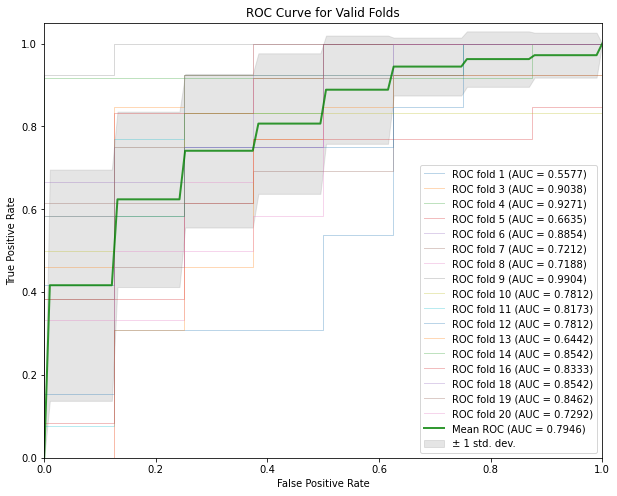

In [20]:

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
seed = 42

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)

# Initialize lists to store evaluation metrics
specificities = []
accuracies = []
sensitivities = []
auc_scores = []

# Initialize lists to store true labels and predicted probabilities for ROC curve
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# Stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=seed)

# Plot setup
plt.figure(figsize=(10, 8))

# Iterate through each fold
valid_folds = 0  # To count valid folds
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = xgb_model.predict(X_test)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate specificity, accuracy, sensitivity, and AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Skip fold if any metric is invalid (i.e., 0 or 1)
    if 0 < auc_score < 1 and 0 < specificity < 1 and 0 < accuracy < 1 and 0 < sensitivity < 1:
        valid_folds += 1  # Increment valid fold count

        # Store valid fold metrics
        auc_scores.append(auc_score)
        specificities.append(specificity)
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate the ROC curve
        tprs[-1][0] = 0.0

        # Plot the ROC curve for the current fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc_score:.4f})')

        print(f'Fold {i} - AUC: {auc_score:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}')
    else:
        print(f"Fold {i} skipped due to invalid metrics (AUC: {auc_score}, Specificity: {specificity}, Accuracy: {accuracy}, Sensitivity: {sensitivity})")

# Plot average ROC curve only if there are valid folds
if valid_folds > 0:
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    plt.plot(mean_fpr, mean_tpr, color='g', label=f'Mean ROC (AUC = {mean_auc:.4f})', lw=2, alpha=0.8)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2, label=r'± 1 std. dev.')

    # ROC curve formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Valid Folds')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("No valid folds to plot.")


# Ploting the result of XGboost with 3 fold-cross validation

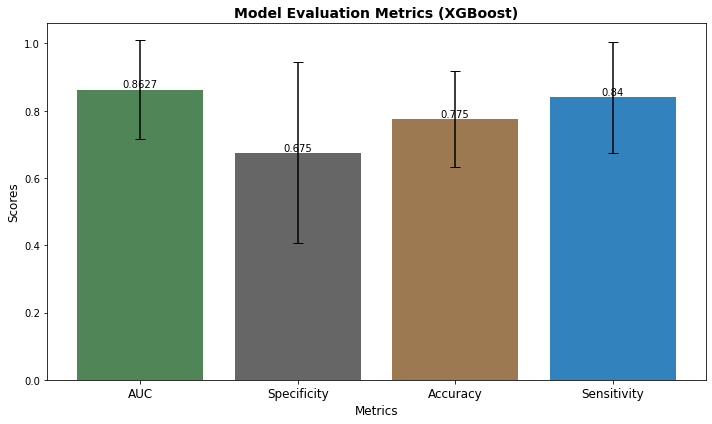

In [16]:
# Calculate mean and standard deviation for each metric
metrics = {
    'AUC': auc_scores,
    'Specificity': specificities,
    'Accuracy': accuracies,
    'Sensitivity': sensitivities
}

means = {metric: np.mean(values) for metric, values in metrics.items()}
stds = {metric: np.std(values) for metric, values in metrics.items()}

# Create a bar plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = list(means.keys())
x = np.arange(len(metric_names))

# Define a muted, professional color palette
colors = ['#508557', '#666666', '#9c7951', '#3182bd']

# Bar plot
bars = ax.bar(x, list(means.values()), yerr=list(stds.values()), capsize=5, color=colors)

# Add title and labels
ax.set_title('Model Evaluation Metrics (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=12)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), ha='center', va='bottom', fontsize=10)

# Improve layout and show plot
plt.tight_layout()
plt.show()


# Comparing the result for XGboost, Catboost, Random Forest, and SVM 
Cross-validated with 5 folds this time. Checkwhich models overfitted!

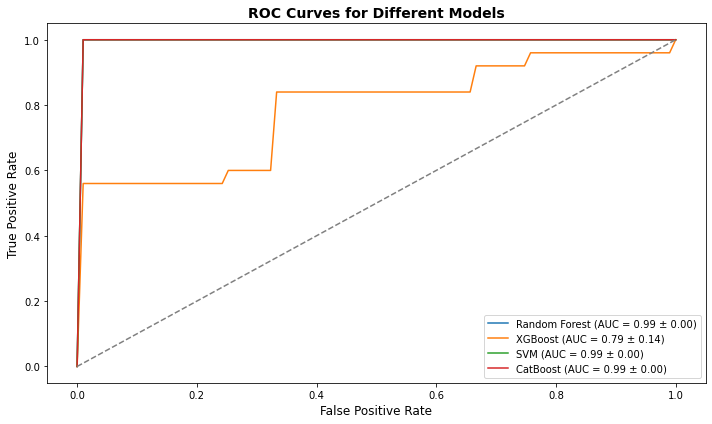

Random Forest - Average AUC: 1.0000 (±0.0000)
XGBoost - Average AUC: 0.7867 (±0.1424)
SVM - Average AUC: 1.0000 (±0.0000)
CatBoost - Average AUC: 1.0000 (±0.0000)


In [17]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', seed=seed),
    'SVM': SVC(probability=True, random_state=seed),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=seed)
}

# Initialize lists to store results
results = {model_name: [] for model_name in models.keys()}
mean_fpr = np.linspace(0, 1, 100)

# Initialize dictionary to store ROC curves
roc_curves = {model_name: [] for model_name in models.keys()}

# Cross-validation
for train_index, test_index in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        results[model_name].append(roc_auc)
        
        # Interpolate the ROC curve
        roc_curves[model_name].append(np.interp(mean_fpr, fpr, tpr))
        roc_curves[model_name][-1][0] = 0.0

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, scores in results.items():
    mean_tpr = np.mean(roc_curves[model_name], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(scores)
    ax.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

# Add diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Add title and labels
ax.set_title('ROC Curves for Different Models', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()

# Print average and standard deviation of AUC scores
for model_name, scores in results.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    print(f'{model_name} - Average AUC: {mean_auc:.4f} (±{std_auc:.4f})')


# Comparing the same models as previously but exploring a bit the land of diverse hyperparameters 
See not much diference result compared with not exploring hyperparameter! useless effort.

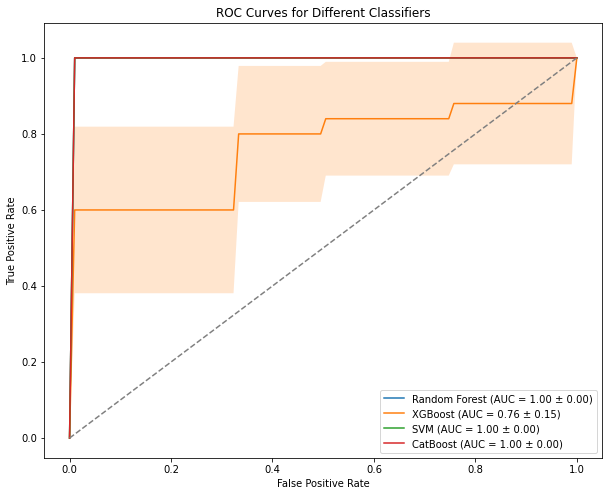

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define classifiers with basic hyperparameters
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

# Hyperparameter grids for tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'CatBoost': {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'iterations': [100, 200]
    }
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results dictionary
results = {name: {'auc': [], 'fpr': [], 'tpr': []} for name in classifiers.keys()}

# Perform cross-validation and hyperparameter tuning
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=cv, scoring='roc_auc')
    grid_search.fit(X_scaled, y)
    best_clf = grid_search.best_estimator_
    
    for train_index, test_index in cv.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        results[name]['auc'].append(auc_score)
        results[name]['fpr'].append(fpr)
        results[name]['tpr'].append(tpr)

# Plotting ROC Curves
plt.figure(figsize=(10, 8))

for name in classifiers.keys():
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    for i in range(len(results[name]['auc'])):
        tprs.append(np.interp(mean_fpr, results[name]['fpr'][i], results[name]['tpr'][i]))
        tprs[-1][0] = 0.0
        aucs.append(auc(results[name]['fpr'][i], results[name]['tpr'][i]))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), alpha=0.2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()


# Selecting top genes based on feature selction analysis:
See also the top 5 common genes 

In [105]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Function to get top n feature importances
def get_top_n_feature_importances(model, X_train, y_train, n=30):
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X1.columns, 'Importance': importances})
    top_n_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(n)['Feature']
    return set(top_n_features)

# Train the Random Forest model and get top 20 important features
rf_model = RandomForestClassifier(random_state=42)
rf_top_features = get_top_n_feature_importances(rf_model, X_train, y_train)
print('Random Forest top 30 genes: ',rf_top_features)
# Train the CatBoost model and get top 20 important features
cat_model = CatBoostClassifier(random_state=42, verbose=0)
cat_top_features = get_top_n_feature_importances(cat_model, X_train, y_train)
print('CatBoost top 30 genes: ',cat_top_features)
# Train the XGBoost model and get top 20 important features
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_top_features = get_top_n_feature_importances(xgb_model, X_train, y_train)
print('XGBoost top 30 genes: ',xgb_top_features)
# Train the AdaBoost model and get top 20 important features
ada_model = AdaBoostClassifier(random_state=42)
ada_top_features = get_top_n_feature_importances(ada_model, X_train, y_train)
print('AdaBoost top 30 genes: ',ada_top_features)
# Find the intersection of top features
common_features = rf_top_features.intersection(cat_top_features).intersection(xgb_top_features).intersection(ada_top_features)

print("Common Important Features Across All Models:")
print(common_features)


Random Forest top 30 genes:  {'ENST00000507126', 'ENST00000298317', 'ENST00000381724', 'ENST00000379446', 'ENST00000483001', 'ENST00000531904', 'ENST00000570209', 'ENST00000472481', 'ENST00000362698', 'ENST00000494302', 'ENST00000484279', 'ENST00000360526', 'ENST00000401030', 'ENST00000514815', 'ENST00000343137', 'ENST00000564468', 'ENST00000425184', 'ENST00000395496', 'ENST00000468234', 'ENST00000252951', 'ENST00000329908', 'ENST00000591566', 'ENST00000409224', 'ENST00000442664', 'ENST00000486777', 'ENST00000532317', 'ENST00000373064', 'ENST00000529713', 'ENST00000391141', 'ENST00000356708'}
CatBoost top 30 genes:  {'ENST00000519295', 'ENST00000507126', 'ENST00000298317', 'ENST00000381724', 'ENST00000379446', 'ENST00000483001', 'ENST00000650479', 'ENST00000531904', 'ENST00000489671', 'ENST00000570209', 'ENST00000472481', 'ENST00000446033', 'ENST00000383374', 'ENST00000494302', 'ENST00000473243', 'ENST00000514815', 'ENST00000343137', 'ENST00000564468', 'ENST00000591566', 'ENST000005140

# Take the top 5 genes and do a new ML (logistic regression)
See AUC less overfitted!

In [91]:
# Select common features from the dataset
X_common = X1[list(common_features)]

# Standardize the common features
X_common_scaled = scaler.fit_transform(X_common)

# Split the data using common features
X_train_common, X_test_common, y_train_common, y_test_common = train_test_split(X_common_scaled, y, test_size=0.4, random_state=42)

# Train a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_common, y_train_common)

# Predict probabilities
y_pred_prob = logreg_model.predict_proba(X_test_common)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test_common, y_pred_prob)
print("AUC Score for Logistic Regression model using common features:", auc_score)

AUC Score for Logistic Regression model using common features: 0.8571428571428572


# Check other metrics as well for the previous example:

Accuracy for Logistic Regression model using common features: 0.7058823529411765
Sensitivity (Recall) for Logistic Regression model using common features: 1.0
Specificity for Logistic Regression model using common features: 0.2857142857142857


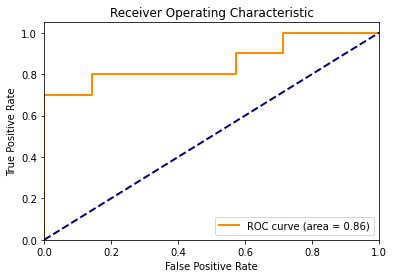

In [92]:
# Predict labels
y_pred = logreg_model.predict(X_test_common)

# Compute accuracy
accuracy = accuracy_score(y_test_common, y_pred)
print("Accuracy for Logistic Regression model using common features:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_common, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Compute specificity and sensitivity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity (Recall) for Logistic Regression model using common features:", sensitivity)
print("Specificity for Logistic Regression model using common features:", specificity)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_common, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Top 5 common genes and Catboost performance:
check how it shows less overfitted result, maybe good sign?

AUC Score for CatBoost model using common features: 0.7285714285714286
Accuracy for CatBoost model using common features: 0.7647058823529411
Sensitivity (Recall) for CatBoost model using common features: 1.0
Specificity for CatBoost model using common features: 0.42857142857142855


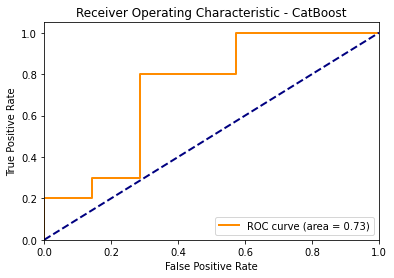

In [93]:
# Use the common features
X_common = X1[list(common_features)]

# Standardize the common features
X_common_scaled = scaler.fit_transform(X_common)

# Split the data using common features
X_train_common, X_test_common, y_train_common, y_test_common = train_test_split(X_common_scaled, y, test_size=0.4, random_state=42)

# Train a CatBoost model
cat_model_common = CatBoostClassifier(random_state=42, verbose=0)
cat_model_common.fit(X_train_common, y_train_common)

# Predict probabilities
y_pred_prob_cat = cat_model_common.predict_proba(X_test_common)[:, 1]

# Predict labels
y_pred_cat = cat_model_common.predict(X_test_common)

# Compute AUC score
auc_score_cat = roc_auc_score(y_test_common, y_pred_prob_cat)
print("AUC Score for CatBoost model using common features:", auc_score_cat)

# Compute accuracy
accuracy_cat = accuracy_score(y_test_common, y_pred_cat)
print("Accuracy for CatBoost model using common features:", accuracy_cat)

# Compute confusion matrix
conf_matrix_cat = confusion_matrix(y_test_common, y_pred_cat)
tn_cat, fp_cat, fn_cat, tp_cat = conf_matrix_cat.ravel()

# Compute specificity and sensitivity
sensitivity_cat = tp_cat / (tp_cat + fn_cat)
specificity_cat = tn_cat / (tn_cat + fp_cat)

print("Sensitivity (Recall) for CatBoost model using common features:", sensitivity_cat)
print("Specificity for CatBoost model using common features:", specificity_cat)

# Plot ROC curve
fpr_cat, tpr_cat, _ = roc_curve(y_test_common, y_pred_prob_cat)
plt.figure()
plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score_cat)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CatBoost')
plt.legend(loc="lower right")
plt.show()


# Trying Lasso and Ridge Regression to overcome overfitting 
See how Lasso is doing better and Ridge regression failed!

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.5, random_state=42)

# Lasso Regression with L1 regularization
lasso_model = Lasso(alpha=0.1, max_iter=1000)  # alpha is the regularization strength
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)
y_pred_lasso_class = (y_pred_lasso > 0.5).astype(int)  # convert probabilities to class labels

print("Lasso Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lasso_class))
print("Classification Report:\n", classification_report(y_test, y_pred_lasso_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lasso_class))

# Ridge Regression with L2 regularization
ridge_model = Ridge(alpha=1.0, max_iter=1000)  # alpha is the regularization strength
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
y_pred_ridge_class = (y_pred_ridge > 0.5).astype(int)  # convert probabilities to class labels

print("\nRidge Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_ridge_class))
print("Classification Report:\n", classification_report(y_test, y_pred_ridge_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ridge_class))

Lasso Regression Results:
Accuracy: 0.8095238095238095
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.91      0.77      0.83        13

    accuracy                           0.81        21
   macro avg       0.80      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

Confusion Matrix:
 [[ 7  1]
 [ 3 10]]

Ridge Regression Results:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        13

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Confusion Matrix:
 [[ 8  0]
 [ 0 13]]


In [106]:
current_date = datetime.now().date()
print("Last update :", current_date)

Last update : 2024-07-03


In [122]:
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Create a simple dataset
# Features: [study_hours, attendance]
X = np.array([[1, 3], [2, 6], [3, 9], [4, 12], [5, 15], [6, 18]])
# Target: 0 = fail, 1 = pass
y = np.array([0, 0, 0, 1, 1, 1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train a simple model
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [123]:
# Create an explainer for the model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Print the SHAP values for the first test example
print("SHAP values for the first test example:", shap_values[1][0])
print("Features:", X_test[0])


SHAP values for the first test example: [-0.14666667 -0.19      ]
Features: [1 3]


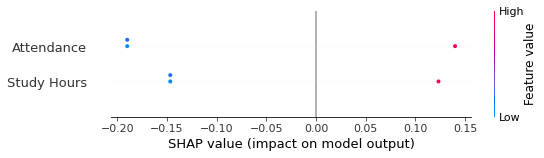

In [124]:
# Visualize the SHAP values for the test set
shap.summary_plot(shap_values[1], X_test, feature_names=["Study Hours", "Attendance"])
